In [283]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler
from imblearn.pipeline import Pipeline as ImbPipeline


In [288]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset: ", path)

Path to dataset:  /Users/alejandrodiazalvarado/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [289]:
df = pd.read_csv(path+"/WA_Fn-UseC_-Telco-Customer-Churn.csv") #Replace route with the actual path
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


----------------------------------
Exploratory Data Analysis (EDA)
----------------------------------

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [256]:
#Check null values
print(df[df.isnull().any(axis=1)].count())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [257]:
#Check number of churn 
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


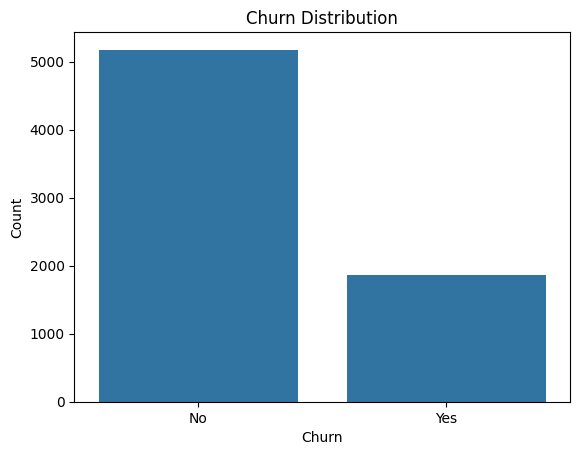

In [258]:
#Churn graph
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [259]:
#Check TotalCharges values
print(df['TotalCharges'].describe())

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object


In [260]:
#Check for non-numeric values in TotalCharges
non_numeric_total_charges = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()]
print(non_numeric_total_charges)
non_numeric_total_charges.style.format({df.columns[18]: "{:.3f}"})

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ... 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,,No


In [261]:
#Convert TotalCharges to numeric, forcing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.loc[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [262]:
#Now, fill the NaN values in TotalCharges with the mean of the column
mean_total_charges = df['TotalCharges'].mean()
df.fillna({'TotalCharges': mean_total_charges}, inplace=True)


In [12]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [263]:
#Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 0


In [264]:
#Check unique values
for col in df.columns:
    print(f"Unique values in {col}: {df[col].nunique()}")

Unique values in customerID: 7043
Unique values in gender: 2
Unique values in SeniorCitizen: 2
Unique values in Partner: 2
Unique values in Dependents: 2
Unique values in tenure: 73
Unique values in PhoneService: 2
Unique values in MultipleLines: 3
Unique values in InternetService: 3
Unique values in OnlineSecurity: 3
Unique values in OnlineBackup: 3
Unique values in DeviceProtection: 3
Unique values in TechSupport: 3
Unique values in StreamingTV: 3
Unique values in StreamingMovies: 3
Unique values in Contract: 3
Unique values in PaperlessBilling: 2
Unique values in PaymentMethod: 4
Unique values in MonthlyCharges: 1585
Unique values in TotalCharges: 6531
Unique values in Churn: 2


-----------------
Data visualization
-----

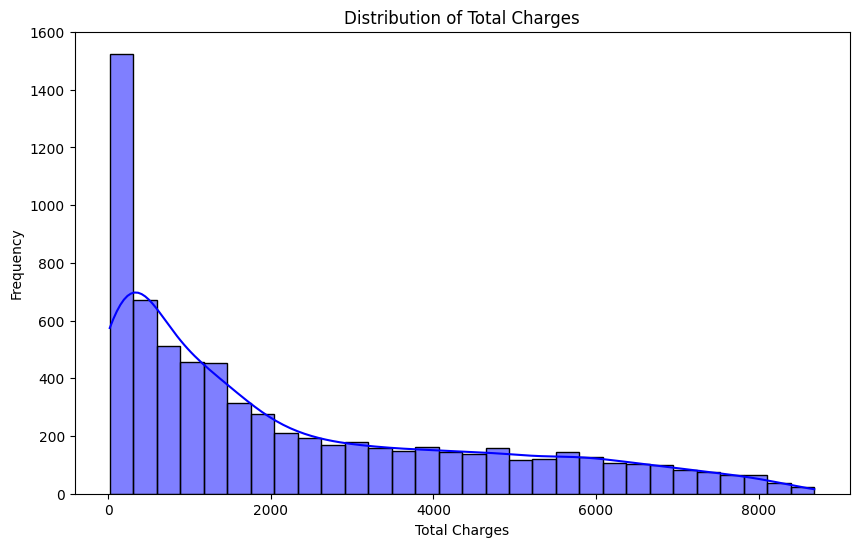

In [265]:
#Distribution of total charges
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalCharges'], bins=30, kde=True, color='blue')
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

In [266]:
Q1 = df['TotalCharges'].quantile(0.25)
Q3 = df['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
out = df[(df['TotalCharges'] < lower_bound)]
print(out)

Q1: 402.225, Q3: 3786.6, IQR: 3384.375
Lower Bound: -4674.3375, Upper Bound: 8863.1625
Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]


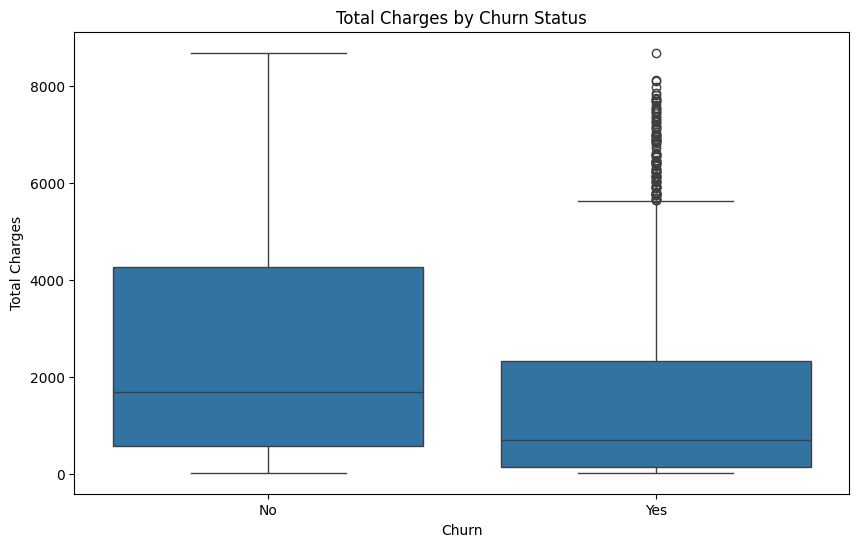

In [267]:
#Distribution of total charges by churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=df)   
plt.title('Total Charges by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

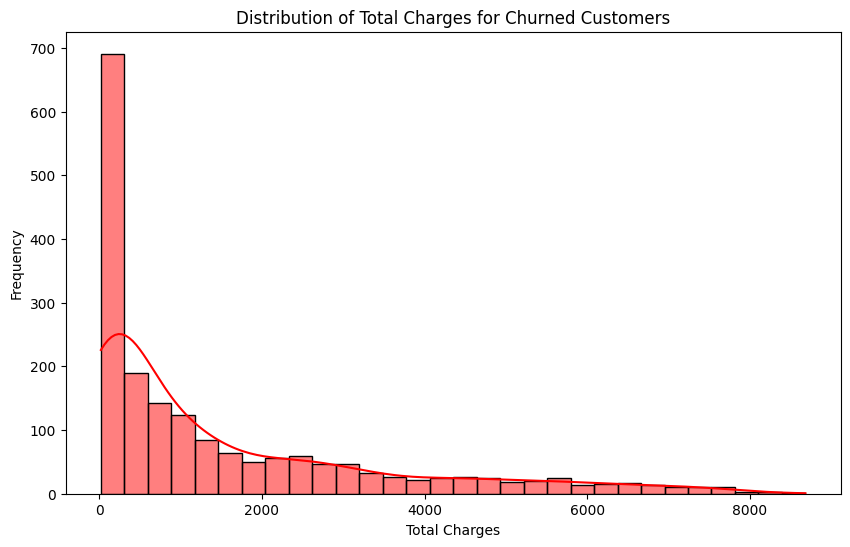

In [268]:
#Distribution of total charges by churn = Yes
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Churn'] == 'Yes']['TotalCharges'], bins=30, kde=True, color='red')
plt.title('Distribution of Total Charges for Churned Customers')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

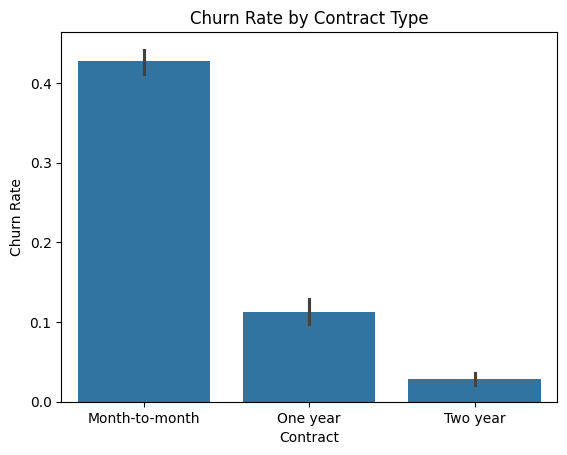

In [269]:
#Churn rate by categorical features
sns.barplot(x='Contract', y=df['Churn'].map({'No':0, 'Yes':1}), data=df)
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate')
plt.show()

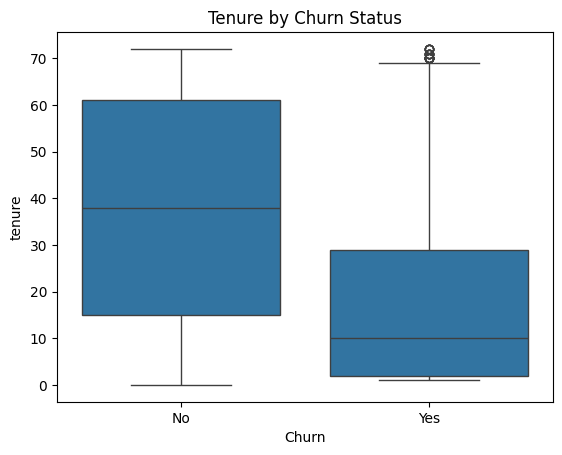

In [276]:
#Tenure by churn status
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure by Churn Status')
plt.show()

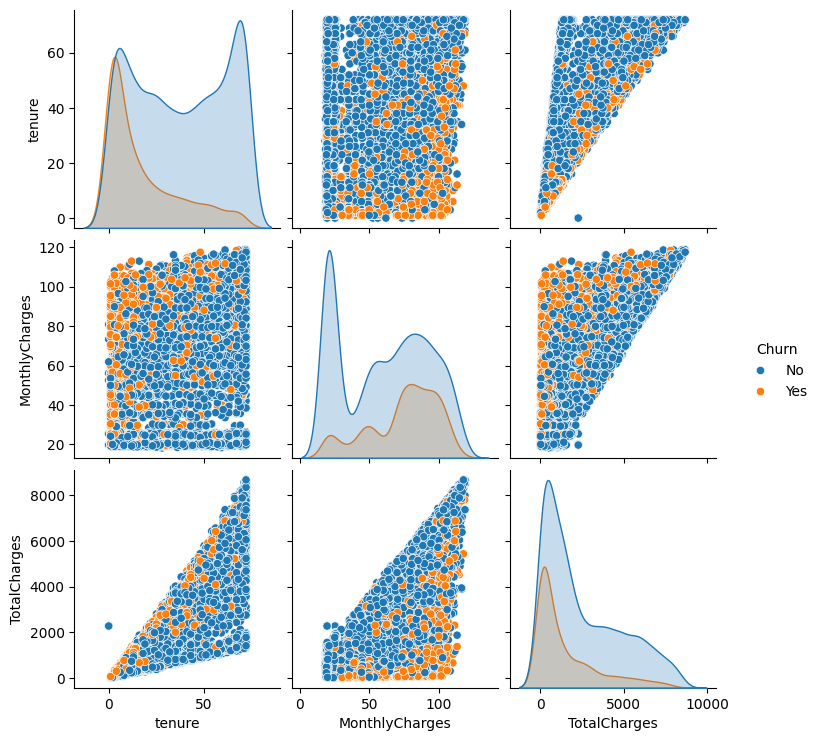

In [277]:
sns.pairplot(df, vars=['tenure', 'MonthlyCharges', 'TotalCharges'], hue='Churn')
plt.show()

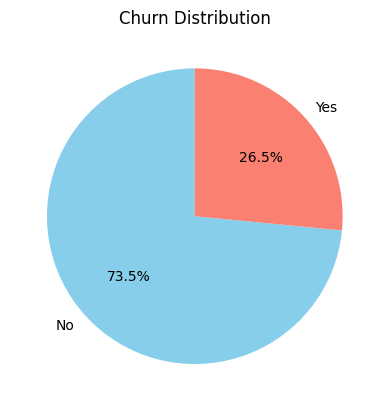

In [279]:
#Churn distribution
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.ylabel('')
plt.show()

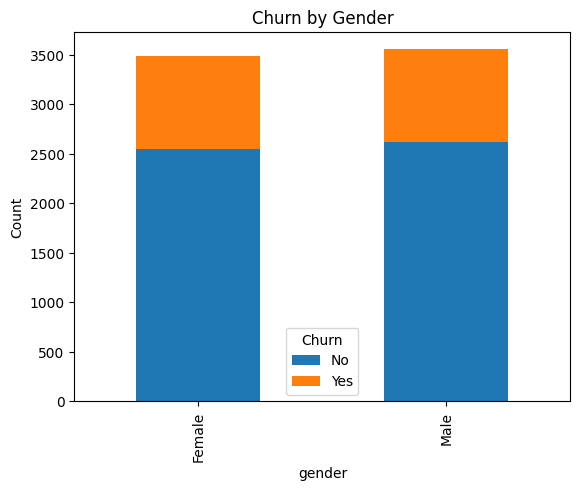

In [281]:
#Churn by gender
pd.crosstab(df['gender'], df['Churn']).plot(kind='bar', stacked=True)
plt.title('Churn by Gender')
plt.ylabel('Count')
plt.show()

In [284]:
#unique values
for col in df.columns:
    print(f"Unique values in {col}: {df[col].unique()}")

Unique values in customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in gender: ['Female' 'Male']
Unique values in SeniorCitizen: [0 1]
Unique values in Partner: ['Yes' 'No']
Unique values in Dependents: ['No' 'Yes']
Unique values in tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Unique values in PhoneService: ['No' 'Yes']
Unique values in MultipleLines: ['No phone service' 'No' 'Yes']
Unique values in InternetService: ['DSL' 'Fiber optic' 'No']
Unique values in OnlineSecurity: ['No' 'Yes' 'No internet service']
Unique values in OnlineBackup: ['Yes' 'No' 'No internet service']
Unique values in DeviceProtection: ['No' 'Yes' 'No internet service']
Unique values in TechSupport: ['No' 'Yes' 'No internet service']
Unique values in StreamingTV: ['No' '

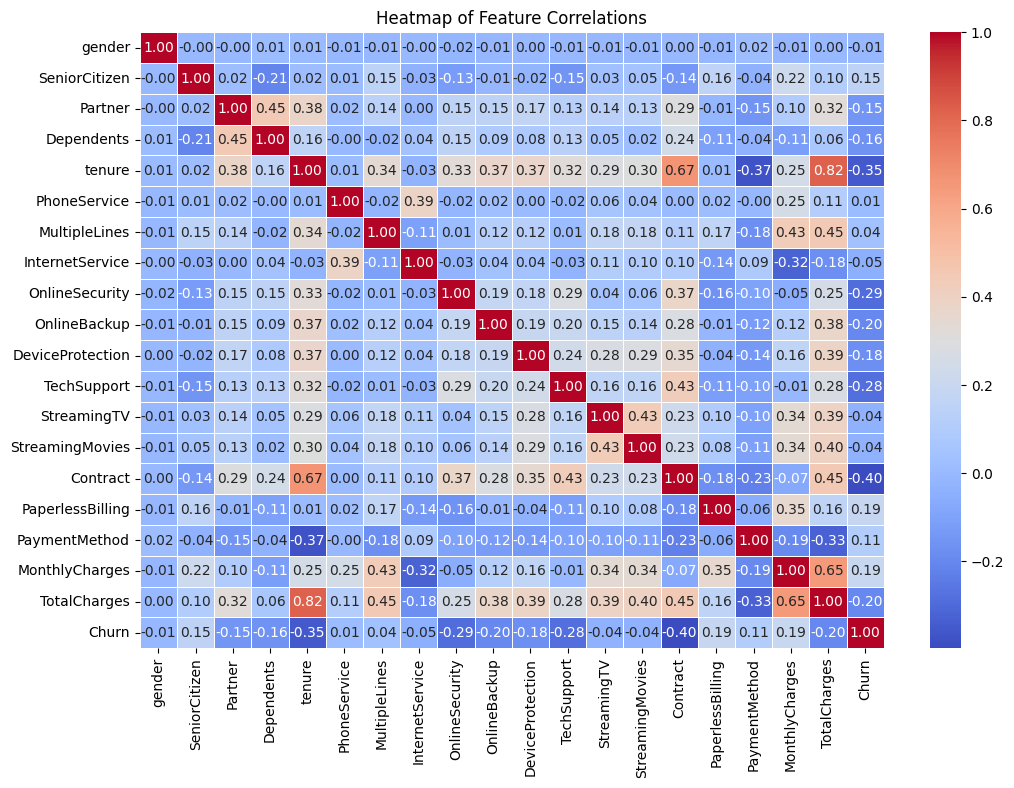

In [287]:
#Heatmap graphic
#First, create a copy of the dataframe
df_heatmap = df.copy()

#Drop unnecessary columns
df_heatmap.drop(['customerID'], axis=1, inplace=True)

#Now, convert object values to numeric
binary_columns = ["gender", "Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
for col in binary_columns:
    df_heatmap[col] = df_heatmap[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})


#Then, convert categorical columns using one hot encoding and ordinal encoding
categorical_columns = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"]
encoder = OrdinalEncoder()

df_heatmap[categorical_columns] = encoder.fit_transform(df_heatmap[categorical_columns])

#heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Heatmap of Feature Correlations")
plt.show()



------------------------------
Data Manipulation
------------------------------

In [188]:
#Copy the DataFrame
df_copy = df.copy()


In [189]:
#Drop customerID column
df_copy.drop(columns=['customerID'], inplace=True)

In [190]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [191]:
for col in df_copy.columns:
    print(f"Unique values in {col}: {df_copy[col].nunique()}")

Unique values in gender: 2
Unique values in SeniorCitizen: 2
Unique values in Partner: 2
Unique values in Dependents: 2
Unique values in tenure: 73
Unique values in PhoneService: 2
Unique values in MultipleLines: 3
Unique values in InternetService: 3
Unique values in OnlineSecurity: 3
Unique values in OnlineBackup: 3
Unique values in DeviceProtection: 3
Unique values in TechSupport: 3
Unique values in StreamingTV: 3
Unique values in StreamingMovies: 3
Unique values in Contract: 3
Unique values in PaperlessBilling: 2
Unique values in PaymentMethod: 4
Unique values in MonthlyCharges: 1585
Unique values in TotalCharges: 6531
Unique values in Churn: 2


In [192]:
#Define features and target
X_p = df_copy.drop('Churn', axis=1)
y_p = df_copy['Churn']

#Split the data
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_p, y_p, test_size=0.2, random_state=42)


------------------------
Create the Pipeline
--

In [ ]:
#Build pipeline to transform the dataframe

#Pipeline for binary values
binary_values = ColumnTransformer([
    (
        'binary',
        OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
        ["gender", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]
        
    )
])


#Pipeline for dummy variables
dummies_values = ColumnTransformer([
    (
        'dummies',
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"]
    )
])

#Passthrough for numerical features
numerical_values = ColumnTransformer([
    (
        'numerical',
        'passthrough',
        ['SeniorCitizen','tenure', 'MonthlyCharges', 'TotalCharges']
    )
])

#Feature union
feature_union = FeatureUnion([
    ('binary', binary_values),
    ('dummies', dummies_values),
    ('numerical', numerical_values)
])

#Final pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', feature_union),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [194]:
rf_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('binary', ...), ('dummies', ...), ...]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,categories,'auto'
,drop,None


In [195]:
#Fit the pipeline on training data
rf_pipeline.fit(Xp_train, yp_train)

#Predict churn
yp_pred_rf = rf_pipeline.predict(Xp_test)

#Evaluate the model
print(classification_report(yp_test, yp_pred_rf))

              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1036
         Yes       0.65      0.45      0.53       373

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [196]:
#Pipeline for Logistic Regression

#Final pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', feature_union),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])

In [197]:
lr_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('binary', ...), ('dummies', ...), ...]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,categories,'auto'
,drop,None


In [198]:
lr_pipeline.fit(Xp_train, yp_train)

lr_y_pred = lr_pipeline.predict(Xp_test)

# Evaluate the model
print(classification_report(yp_test, lr_y_pred))

              precision    recall  f1-score   support

          No       0.86      0.90      0.88      1036
         Yes       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



--------------
Create Pipeline using feature engineering
---

In [ ]:

#Define a function for feature engineering
def num_services(Z):
    Z = Z.copy()
    Z['NumServices'] = (
        (Z['PhoneService'] == 'Yes').astype(int) +
        (Z['MultipleLines'] == 'Yes').astype(int) +
        (Z['InternetService'] != 'No').astype(int) +
        (Z['OnlineSecurity'] == 'Yes').astype(int) +
        (Z['OnlineBackup'] == 'Yes').astype(int) +
        (Z['DeviceProtection'] == 'Yes').astype(int) +
        (Z['TechSupport'] == 'Yes').astype(int) +
        (Z['StreamingTV'] == 'Yes').astype(int) +
        (Z['StreamingMovies'] == 'Yes').astype(int)
    )
    return Z
fe = FunctionTransformer(num_services)

#Define a function to scale the tenure column
def scale_tenure(Z):
    Z = Z.copy()
    scaler = MinMaxScaler()
    Z['tenure_scaled'] = scaler.fit_transform(Z[['tenure']])
    return Z

scale_tenure_transformer = FunctionTransformer(scale_tenure)

#Now, let's create a new pipeline with feature engineering
lr_pipeline_fe = Pipeline(steps=[
    ('scale_tenure', scale_tenure_transformer),
    ('feature_engineering', fe),
    ('preprocessor', feature_union),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])

In [238]:
lr_pipeline_fe

,steps,"[('scale_tenure', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function sca...t 0x1156282c0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [239]:
#Train the new pipeline
lr_pipeline_fe.fit(Xp_train, yp_train)

#Predict churn
lr_fe_yp_pred = lr_pipeline_fe.predict(Xp_test)

#Evaluate the model
print(classification_report(yp_test, lr_fe_yp_pred))

              precision    recall  f1-score   support

          No       0.86      0.90      0.88      1036
         Yes       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



In [202]:
#Create a pipeline using Random Forest
rf_pipeline_fe = Pipeline(steps=[
    ('scale_tenure', scale_tenure_transformer),
    ('feature_engineering', fe),
    ('preprocessor', feature_union),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline_fe

,steps,"[('scale_tenure', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function sca...t 0x111911080>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [203]:
#Train the new pipeline (Random forest)
rf_pipeline_fe.fit(Xp_train, yp_train)

#Predict churn
rf_fe_yp_pred = rf_pipeline_fe.predict(Xp_test)

#Evaluate the model
print(classification_report(yp_test, rf_fe_yp_pred))

              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1036
         Yes       0.65      0.45      0.53       373

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



------------------
Pipeline using Feature Selection
-----------

In [206]:
feature_selector = SelectKBest(score_func=f_classif, k=10)

rf_pipeline_fs = Pipeline(steps=[
    ('preprocessor', feature_union),
    ('feature_selection', feature_selector),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline_fs

,steps,"[('preprocessor', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('binary', ...), ('dummies', ...), ...]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,categories,'auto'
,drop,None


In [207]:
#Train the new pipeline (Random forest)
rf_pipeline_fs.fit(Xp_train, yp_train)

#Predict churn
rf_fs_yp_pred = rf_pipeline_fs.predict(Xp_test)

#Evaluate the model
print(classification_report(yp_test, rf_fs_yp_pred))

              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1036
         Yes       0.63      0.47      0.54       373

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409



In [210]:
lr_pipeline_fs = Pipeline(steps=[
    ('preprocessor', feature_union),
    ('feature_selection', feature_selector),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])

lr_pipeline_fs

,steps,"[('preprocessor', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('binary', ...), ('dummies', ...), ...]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,categories,'auto'
,drop,None


In [211]:
#Train the new pipeline (Logistic Regression)
lr_pipeline_fs.fit(Xp_train, yp_train)

#Predict churn
lr_fs_yp_pred = lr_pipeline_fs.predict(Xp_test)

#Evaluate the model
print(classification_report(yp_test, lr_fs_yp_pred))

              precision    recall  f1-score   support

          No       0.86      0.91      0.88      1036
         Yes       0.69      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



-----------------------------------------------------------
Feature Selection + Feature Engineering
-----------------------------------------------------------

In [212]:
pipeline_fs_fe_lr = Pipeline(steps=[
    ('scale_tenure', scale_tenure_transformer),
    ('feature_engineering', fe),
    ('preprocessor', feature_union),
    ('feature_selection', feature_selector),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])
pipeline_fs_fe_lr

,steps,"[('scale_tenure', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function sca...t 0x111911080>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [213]:
#Train the new pipeline (Logistic Regression)
pipeline_fs_fe_lr.fit(Xp_train, yp_train)

#Predict churn
lr_fs_fe_yp_pred = pipeline_fs_fe_lr.predict(Xp_test)

#Evaluate the model
print(classification_report(yp_test, lr_fs_fe_yp_pred))

              precision    recall  f1-score   support

          No       0.86      0.91      0.88      1036
         Yes       0.69      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



In [214]:
pipeline_fs_fe_rf = Pipeline(steps=[
    ('scale_tenure', scale_tenure_transformer),
    ('feature_engineering', fe),
    ('preprocessor', feature_union),
    ('feature_selection', feature_selector),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_fs_fe_rf

,steps,"[('scale_tenure', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function sca...t 0x111911080>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [215]:
#Train the new pipeline (Random Forest)
pipeline_fs_fe_rf.fit(Xp_train, yp_train)

#Predict churn
rf_fs_fe_yp_pred = pipeline_fs_fe_rf.predict(Xp_test)

#Evaluate the model
print(classification_report(yp_test, rf_fs_fe_yp_pred))

              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1036
         Yes       0.63      0.47      0.54       373

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409



---
Using apply SMOTE
---

In [216]:
#Create a pipeline using SMOTE
pipeline_smote = Pipeline(steps=[
    ('preprocessor', feature_union),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_smote

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('binary', ...), ('dummies', ...), ...]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,categories,'auto'
,drop,None


In [ ]:


# Recreate the pipeline using imblearn's Pipeline
pipeline_smote_rf = ImbPipeline(steps=[
    ('scale_tenure', scale_tenure_transformer),
    ('feature_engineering', fe),
	('preprocessor', feature_union),
	('smote', SMOTE(random_state=42)),
	('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit and evaluate
pipeline_smote_rf.fit(Xp_train, yp_train)
rf_smote_yp_pred = pipeline_smote_rf.predict(Xp_test)
print(classification_report(yp_test, rf_smote_yp_pred))

              precision    recall  f1-score   support

          No       0.83      0.91      0.87      1036
         Yes       0.66      0.50      0.57       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [241]:
#Logistic Regression
pipeline_smote_lr = ImbPipeline(steps=[
    ('scale_tenure', scale_tenure_transformer),
    ('feature_engineering', fe),
	('preprocessor', feature_union),
	('smote', SMOTE(random_state=42)),
	('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])

# Fit and evaluate
pipeline_smote_lr.fit(Xp_train, yp_train)
lr_smote_yp_pred = pipeline_smote_lr.predict(Xp_test)
print(classification_report(yp_test, lr_smote_yp_pred))

              precision    recall  f1-score   support

          No       0.93      0.73      0.82      1036
         Yes       0.53      0.84      0.65       373

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



----
Comparing the models with diferent variables
---

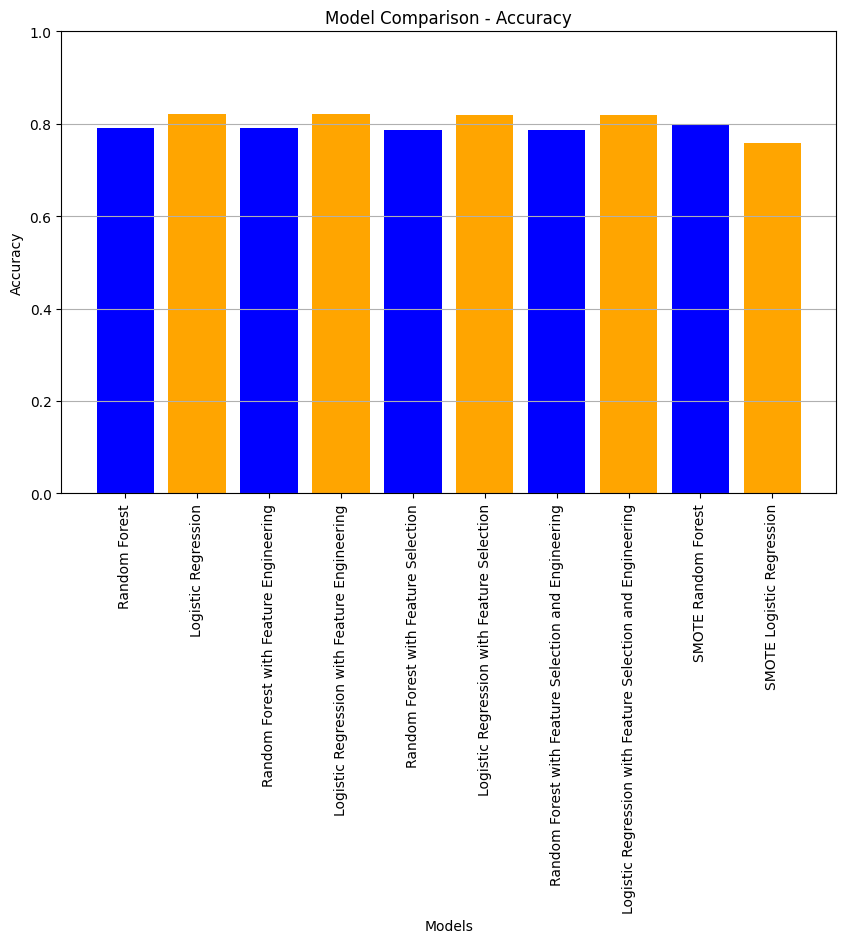

In [227]:
#Comparing pipelines
rf_accuracy = accuracy_score(yp_test, rf_pipeline.predict(Xp_test))
lr_accuracy = accuracy_score(yp_test, lr_pipeline.predict(Xp_test))
rf_fe_accuracy = accuracy_score(yp_test, rf_pipeline_fe.predict(Xp_test))
lr_fe_accuracy = accuracy_score(yp_test, lr_pipeline_fe.predict(Xp_test))
rf_fs_accuracy = accuracy_score(yp_test, rf_pipeline_fs.predict(Xp_test))
lr_fs_accuracy = accuracy_score(yp_test, lr_pipeline_fs.predict(Xp_test))
rf_fs_fe_accuracy = accuracy_score(yp_test, pipeline_fs_fe_rf.predict(Xp_test))
lr_fs_fe_accuracy = accuracy_score(yp_test, pipeline_fs_fe_lr.predict(Xp_test))
rf_smote_accuracy = accuracy_score(yp_test, pipeline_smote_rf.predict(Xp_test))
lr_smote_accuracy = accuracy_score(yp_test, pipeline_smote_lr.predict(Xp_test))

models = [
    'Random Forest', 'Logistic Regression', 
    'Random Forest with Feature Engineering', 'Logistic Regression with Feature Engineering',
    'Random Forest with Feature Selection', 'Logistic Regression with Feature Selection',
    'Random Forest with Feature Selection and Engineering', 'Logistic Regression with Feature Selection and Engineering',
    'SMOTE Random Forest', 'SMOTE Logistic Regression'
]

accuracies = [
    rf_accuracy, lr_accuracy, 
    rf_fe_accuracy, lr_fe_accuracy,
    rf_fs_accuracy, lr_fs_accuracy,
    rf_fs_fe_accuracy, lr_fs_fe_accuracy,
    rf_smote_accuracy, lr_smote_accuracy
]

def plot_model_comparison(models, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'orange'])
    plt.title('Model Comparison - Accuracy')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()

plot_model_comparison(models, accuracies)



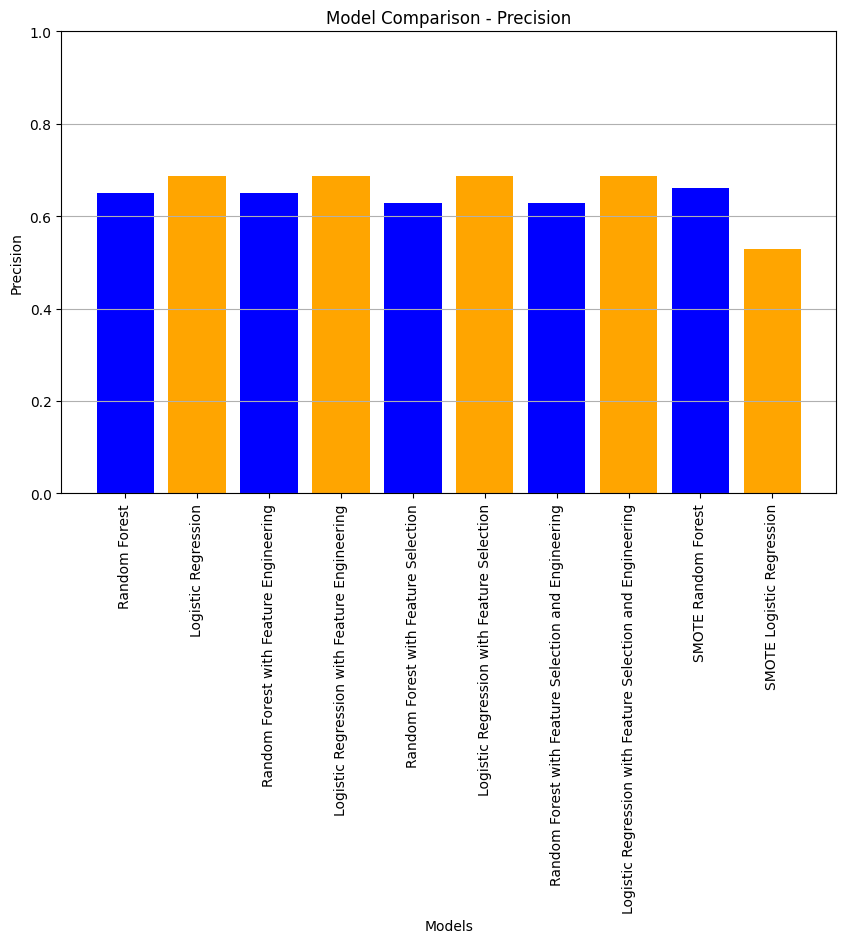

In [ ]:
#Compare pipelines using precision

rf_precision = precision_score(yp_test, rf_pipeline.predict(Xp_test), pos_label='Yes')
lr_precision = precision_score(yp_test, lr_pipeline.predict(Xp_test), pos_label='Yes')
rf_fe_precision = precision_score(yp_test, rf_pipeline_fe.predict(Xp_test), pos_label='Yes')
lr_fe_precision = precision_score(yp_test, lr_pipeline_fe.predict(Xp_test), pos_label='Yes')
rf_fs_precision = precision_score(yp_test, rf_pipeline_fs.predict(Xp_test), pos_label='Yes')
lr_fs_precision = precision_score(yp_test, lr_pipeline_fs.predict(Xp_test), pos_label='Yes')
rf_fs_fe_precision = precision_score(yp_test, pipeline_fs_fe_rf.predict(Xp_test), pos_label='Yes')
lr_fs_fe_precision = precision_score(yp_test, pipeline_fs_fe_lr.predict(Xp_test), pos_label='Yes')
rf_smote_precision = precision_score(yp_test, pipeline_smote_rf.predict(Xp_test), pos_label='Yes')
lr_smote_precision = precision_score(yp_test, pipeline_smote_lr.predict(Xp_test), pos_label='Yes')

precision_scores = [
    rf_precision, lr_precision, 
    rf_fe_precision, lr_fe_precision,
    rf_fs_precision, lr_fs_precision,
    rf_fs_fe_precision, lr_fs_fe_precision,
    rf_smote_precision, lr_smote_precision
]

def plot_precision_comparison(models, precision_scores):
    plt.figure(figsize=(10, 6))
    plt.bar(models, precision_scores, color=['blue', 'orange'])
    plt.title('Model Comparison - Precision')
    plt.xlabel('Models')
    plt.ylabel('Precision')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()

plot_precision_comparison(models, precision_scores)

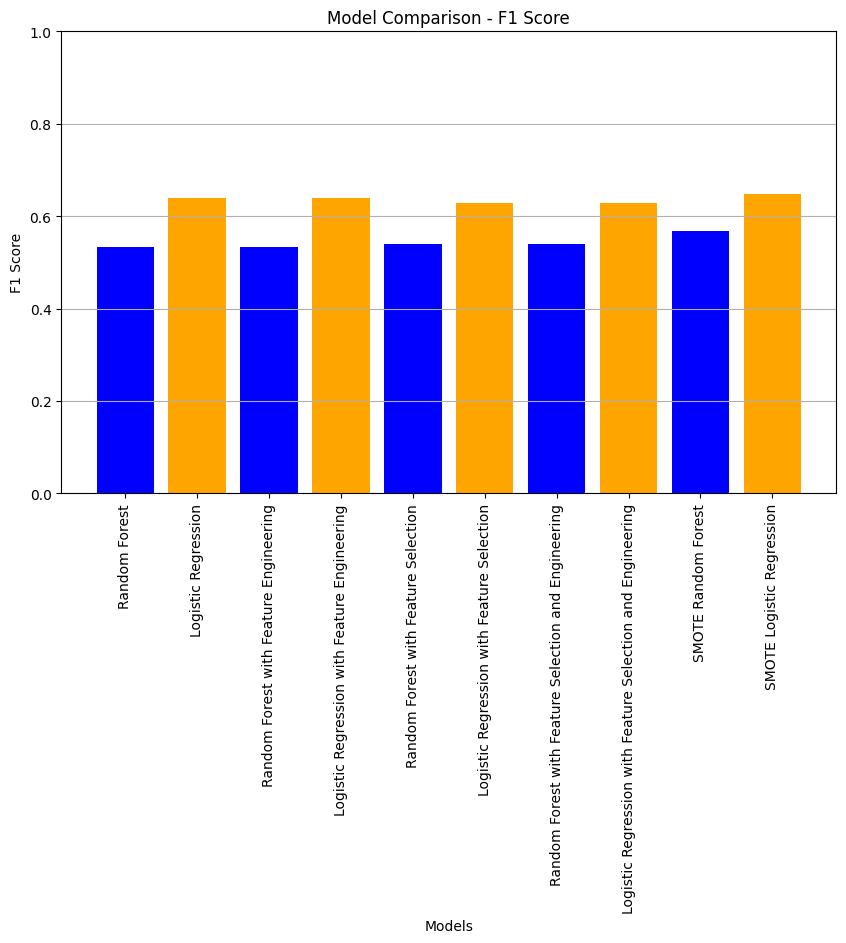

In [ ]:
#Compare pipelines using f1-score

rf_f1 = f1_score(yp_test, rf_pipeline.predict(Xp_test), pos_label='Yes')
lr_f1 = f1_score(yp_test, lr_pipeline.predict(Xp_test), pos_label='Yes')
rf_fe_f1 = f1_score(yp_test, rf_pipeline_fe.predict(Xp_test), pos_label='Yes')
lr_fe_f1 = f1_score(yp_test, lr_pipeline_fe.predict(Xp_test), pos_label='Yes')
rf_fs_f1 = f1_score(yp_test, rf_pipeline_fs.predict(Xp_test), pos_label='Yes')
lr_fs_f1 = f1_score(yp_test, lr_pipeline_fs.predict(Xp_test), pos_label='Yes')
rf_fs_fe_f1 = f1_score(yp_test, pipeline_fs_fe_rf.predict(Xp_test), pos_label='Yes')
lr_fs_fe_f1 = f1_score(yp_test, pipeline_fs_fe_lr.predict(Xp_test), pos_label='Yes')
rf_smote_f1 = f1_score(yp_test, pipeline_smote_rf.predict(Xp_test), pos_label='Yes')
lr_smote_f1 = f1_score(yp_test, pipeline_smote_lr.predict(Xp_test), pos_label='Yes')

f1_scores = [
    rf_f1, lr_f1, 
    rf_fe_f1, lr_fe_f1,
    rf_fs_f1, lr_fs_f1,
    rf_fs_fe_f1, lr_fs_fe_f1,
    rf_smote_f1, lr_smote_f1
]

def plot_f1_comparison(models, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.bar(models, f1_scores, color=['blue', 'orange'])
    plt.title('Model Comparison - F1 Score')
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()

plot_f1_comparison(models, f1_scores)

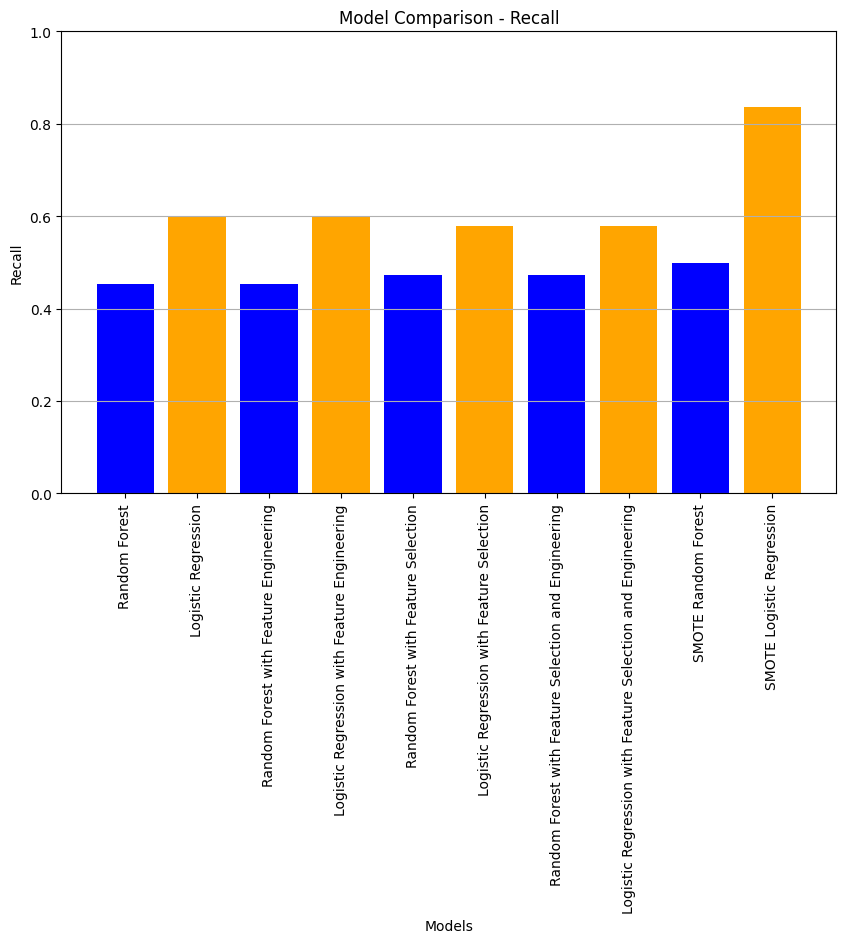

In [ ]:
#Compare pipelines using recall


rf_recall = recall_score(yp_test, rf_pipeline.predict(Xp_test), pos_label='Yes')
lr_recall = recall_score(yp_test, lr_pipeline.predict(Xp_test), pos_label='Yes')
rf_fe_recall = recall_score(yp_test, rf_pipeline_fe.predict(Xp_test), pos_label='Yes')
lr_fe_recall = recall_score(yp_test, lr_pipeline_fe.predict(Xp_test), pos_label='Yes')
rf_fs_recall = recall_score(yp_test, rf_pipeline_fs.predict(Xp_test), pos_label='Yes')
lr_fs_recall = recall_score(yp_test, lr_pipeline_fs.predict(Xp_test), pos_label='Yes')
rf_fs_fe_recall = recall_score(yp_test, pipeline_fs_fe_rf.predict(Xp_test), pos_label='Yes')
lr_fs_fe_recall = recall_score(yp_test, pipeline_fs_fe_lr.predict(Xp_test), pos_label='Yes')
rf_smote_recall = recall_score(yp_test, pipeline_smote_rf.predict(Xp_test), pos_label='Yes')
lr_smote_recall = recall_score(yp_test, pipeline_smote_lr.predict(Xp_test), pos_label='Yes')

recall_scores = [
    rf_recall, lr_recall, 
    rf_fe_recall, lr_fe_recall,
    rf_fs_recall, lr_fs_recall,
    rf_fs_fe_recall, lr_fs_fe_recall,
    rf_smote_recall, lr_smote_recall
]

def plot_recall_comparison(models, recall_scores):
    plt.figure(figsize=(10, 6))
    plt.bar(models, recall_scores, color=['blue', 'orange'])
    plt.title('Model Comparison - Recall')
    plt.xlabel('Models')
    plt.ylabel('Recall')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()

plot_recall_comparison(models, recall_scores)

In [233]:
#Create a dataframe with all metrics
metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precision_scores,
    'F1 Score': f1_scores,
    'Recall': recall_scores
})

metrics_df.style.format({
    "Accuracy": "{:.3f}",
    "Precision": "{:.3f}",
    "F1 Score": "{:.3f}",
    "Recall": "{:.3f}"
})

,Model,Accuracy,Precision,F1 Score,Recall
0,Random Forest,0.791,0.650,0.534,0.453
1,Logistic Regression,0.821,0.686,0.639,0.598
2,Random Forest with Feature Engineering,0.791,0.650,0.534,0.453
3,Logistic Regression with Feature Engineering,0.821,0.686,0.639,0.598
4,Random Forest with Feature Selection,0.786,0.629,0.539,0.472
5,Logistic Regression with Feature Selection,0.819,0.688,0.629,0.579
6,Random Forest with Feature Selection and Engineering,0.786,0.629,0.539,0.472
7,Logistic Regression with Feature Selection and Engineering,0.819,0.688,0.629,0.579
8,SMOTE Random Forest,0.800,0.662,0.569,0.499
9,SMOTE Logistic Regression,0.759,0.529,0.648,0.836
